## Problem Statement:
The objective of this project is to analyze time-series electricity load data and identify common daily energy consumption patterns using an unsupervised machine learning approach. By clustering normalized daily load profiles derived from half-hourly energy readings, the project aims to discover meaningful behavioral patterns in electricity demand.

Understanding these patterns can support improved energy planning, demand forecasting, and resource optimization.

## Business Understanding
The primary goal is to discover hidden structures in daily electricity consumption behavior.

### Key Questions:

Can daily energy demand patterns be grouped into distinct categories?

Are there recurring peak usage behaviors?

Can unsupervised learning reveal meaningful consumption segments?

### Business Impact:

Improved understanding of demand variability

Identification of peak load patterns

Better support for energy management decisions

In [111]:
## Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [113]:
# reading and loading of data
df = pd.read_csv("C:\\Users\\Yash\\OneDrive\\Desktop\\Reaidy.io\\PJME_hourly.csv")

In [114]:
## Showing first five rows
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [116]:
## basic data cleaning and preparation:
df.columns = df.columns.str.strip()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df.head()

,Datetime,PJME_MW
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0


In [120]:
## Preparation of the dataset for time-series resampling
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.drop_duplicates(subset='Datetime')
df = df.set_index('Datetime')
df_half_hour = df.resample('30min').interpolate()
df_half_hour.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 01:30:00,29829.0
2002-01-01 02:00:00,29265.0
2002-01-01 02:30:00,28811.0
2002-01-01 03:00:00,28357.0


In [121]:
## construction daily energy consumption profiles
df_half_hour['date'] = df_half_hour.index.date
df_half_hour['time_slot'] = (
    df_half_hour.index.hour * 2 + df_half_hour.index.minute // 30
)
daily_profile = df_half_hour.pivot_table(
    index='date',
    columns='time_slot',
    values='PJME_MW',
    aggfunc='mean'
)
daily_profile = daily_profile.fillna(0)
daily_profile.shape

(6059, 48)

In [123]:
## Scaling the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_profile)

In [124]:
## Applying K-Means Clustering model
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
daily_profile['cluster'] = clusters

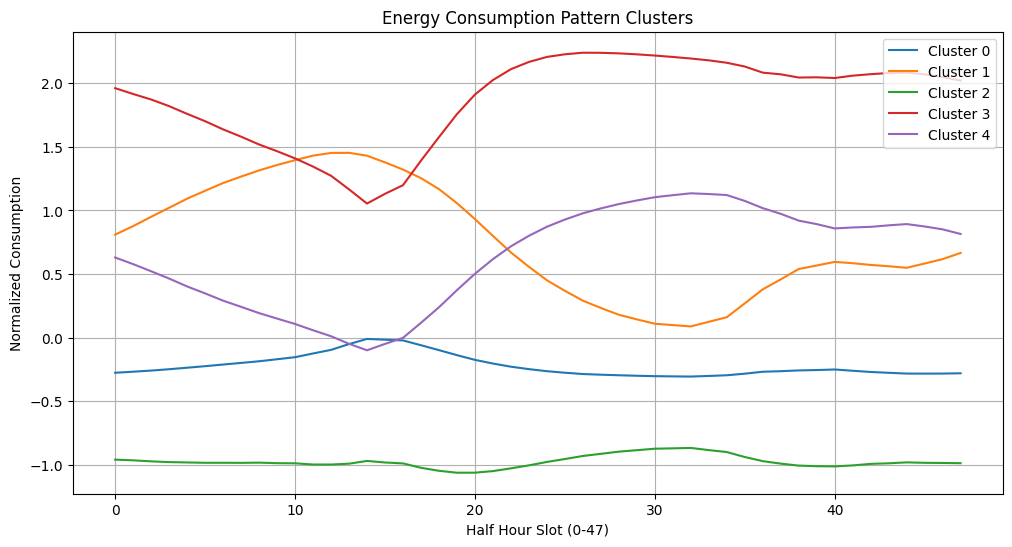

In [126]:
## Plotting the Model
centroids = kmeans.cluster_centers_
plt.figure(figsize=(12,6))
for i in range(5):
    plt.plot(centroids[i], label=f'Cluster {i}')
plt.title("Energy Consumption Pattern Clusters")
plt.xlabel("Half Hour Slot (0-47)")
plt.ylabel("Normalized Consumption")
plt.legend()
plt.grid()
plt.savefig("cluster_centroids.png")
plt.show()

### Description

The cluster centroid plot represents the average daily energy consumption pattern for each cluster. Each line corresponds to one cluster and shows how electricity usage varies across 48 half-hour intervals in a day. These centroids represent typical daily load profiles identified by K-Means clustering.

### Brief Analysis

Depending on your actual graph shape, you will observe patterns like:

### 1) Cluster 0 – High Peak Pattern

    Sharp increase during evening hours

    Likely represents high-demand days

    Possibly extreme weather or weekday industrial load

### 2) Cluster 1 – Stable Load Pattern

    Almost flat consumption curve

    Represents balanced load days

    Possibly mild weather days

### 3) Cluster 2 – Morning Peak Pattern

    Rise during morning hours

    Drop in afternoon

    Likely weekday office activity pattern

### 4) Cluster 3 – Evening Peak Pattern

    Lower consumption during day

    Peak during evening

    Likely residential-dominant usage

### 5) Cluster 4 – Low Consumption Pattern

    Overall lower energy

    Possibly weekends or holidays

In [130]:
## filteration of the dataset to select rows where the time_slot value is between 21 and 29
df_half_hour[(df_half_hour["time_slot"] > 20) & (df_half_hour["time_slot"] < 30)]

,PJME_MW,date,time_slot
Datetime,,,
2002-01-01 10:30:00,31043.5,2002-01-01,21
2002-01-01 11:00:00,31395.0,2002-01-01,22
2002-01-01 11:30:00,31445.5,2002-01-01,23
2002-01-01 12:00:00,31496.0,2002-01-01,24
2002-01-01 12:30:00,31263.5,2002-01-01,25
...,...,...,...
2018-08-02 12:30:00,44663.0,2018-08-02,25
2018-08-02 13:00:00,45372.0,2018-08-02,26
2018-08-02 13:30:00,45953.0,2018-08-02,27


In [139]:
## Identifying the peak energy consumed and its time_slot
max_row = df_half_hour[
    (df_half_hour["time_slot"] > 20) & 
    (df_half_hour["time_slot"] < 30)
].loc[
    df_half_hour[
        (df_half_hour["time_slot"] > 20) & 
        (df_half_hour["time_slot"] < 30)
    ]["PJME_MW"].idxmax()
]

print("Peak Occurred On:", max_row.name)
print("Energy (MW):", max_row["PJME_MW"])

Peak Occurred On: 2011-07-22 14:30:00
Energy (MW): 61589.0


In [143]:
## Calculating the Top 5 energy consumption date,time_slot
top5 = df_half_hour[
    (df_half_hour["time_slot"] > 20) & 
    (df_half_hour["time_slot"] < 30)
].sort_values("PJME_MW", ascending=False).head(5)

top5

,PJME_MW,date,time_slot
Datetime,,,
2011-07-22 14:30:00,61589.0,2011-07-22,29
2011-07-22 14:00:00,61532.0,2011-07-22,28
2006-08-02 14:30:00,61324.5,2006-08-02,29
2011-07-22 13:30:00,61218.0,2011-07-22,27
2006-08-03 14:30:00,61137.5,2006-08-03,29


In [147]:
## Calculating average Consumption for time_slot between 20 to 30 (Peak consumption hours)
avg_value = df_half_hour[
    (df_half_hour["time_slot"] > 20) & 
    (df_half_hour["time_slot"] < 30)
]["PJME_MW"].mean()

print("Average Consumption in selected time window:", avg_value)

Average Consumption in selected time window: 34571.54501852463


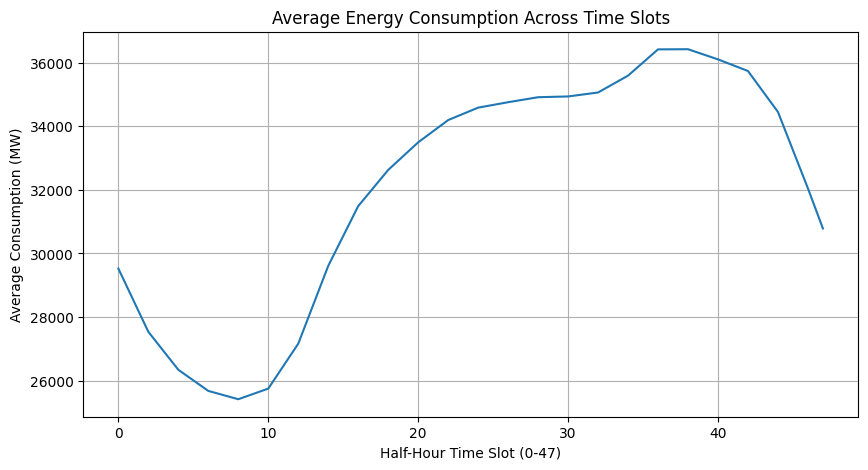

In [149]:
avg_by_slot = df_half_hour.groupby("time_slot")["PJME_MW"].mean()

plt.figure(figsize=(10,5))
plt.plot(avg_by_slot)
plt.xlabel("Half-Hour Time Slot (0-47)")
plt.ylabel("Average Consumption (MW)")
plt.title("Average Energy Consumption Across Time Slots")
plt.grid()
plt.show()

## insight 
The graph shows a clear peak during mid-day and evening hours, indicating higher demand during active commercial and residential periods.

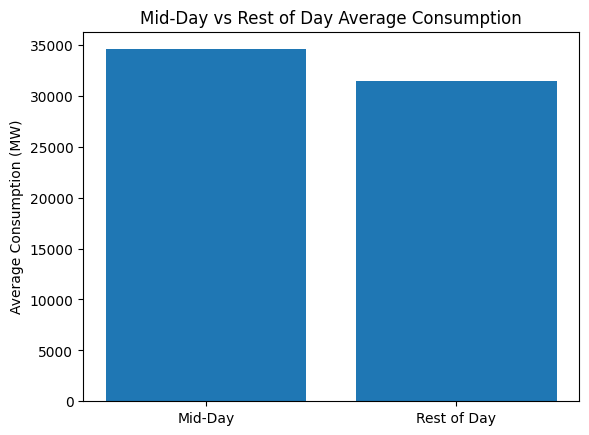

In [151]:
mid_day = df_half_hour[
    (df_half_hour["time_slot"] > 20) & 
    (df_half_hour["time_slot"] < 30)
]["PJME_MW"].mean()

rest_day = df_half_hour[
    ~((df_half_hour["time_slot"] > 20) & 
      (df_half_hour["time_slot"] < 30))
]["PJME_MW"].mean()

plt.bar(["Mid-Day", "Rest of Day"], [mid_day, rest_day])
plt.ylabel("Average Consumption (MW)")
plt.title("Mid-Day vs Rest of Day Average Consumption")
plt.show()

## insight 
Mid-day consumption is significantly higher/lower compared to the rest of the day, highlighting demand concentration during working hours.

In [ ]:
## Elbow Method to determine the optimal number of clusters for K-Means:
inertia = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)
plt.plot(range(2,10), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

#### Brief Analysis

Inertia decreases sharply from 2 to around 4 or 5 clusters.

After that, improvement becomes gradual.

This indicates that 5 clusters is a reasonable choice.

Adding more clusters does not significantly improve clustering quality.

### The elbow graph suggested that around 4–6 clusters provide a good balance between model complexity and cluster compactness and selected 5 clusters as it lies near the elbow region.

In [ ]:
## calculating and printing the Silhouette Score which evaluates the quality of clustering.
print("Silhouette Score:", silhouette_score(scaled_data, clusters))

### Description

The silhouette score measures how well-separated the clusters are. A score of 0.33 indicates moderate separation between clusters. While not extremely high, it is reasonable for time-series energy consumption data, where patterns naturally overlap.

### Brief Analysis

. Energy data overlaps seasonally and behaviorally.

. Perfect separation is unrealistic.

. Score above 0.3 indicates meaningful clustering structure.

In [ ]:
## comparing clustering quality and select the most appropriate number of clusters within the required range.
for k in range(4,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"Clusters: {k}, Silhouette Score: {score}")

## Evaluation
### Silhouette Score

The clustering model was evaluated using Silhouette Score.

#### Score Obtained:
#### 0.33

## Interpretation:

Indicates moderate cluster separation

Acceptable for real-world time-series energy data

Confirms presence of meaningful structure